In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
#import tifffile
import sys
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval


In [2]:
WORKDIR='/home/lapy/PhD/Courses/MachineLearning/Project2/'
SRC = os.path.join(WORKDIR, 'gravitational_lens_ml/src')
DATA = os.path.join(WORKDIR,'')
RESULTS = os.path.join(WORKDIR, 'gravitational_lens_ml/results')
TRAIN = os.path.join(DATA, 'datapack2.0train/')
#TEST = os.path.join(DATA, 'datapack2.0test/')
TRAIN_MULTIBAND = os.path.join(DATA, 'train_multiband')
#TEST_MULTIBAND = os.path.join(DATA, 'test_multiband')

In [3]:
image_catalog = pd.read_csv(os.path.join(DATA, 'datapack2.0train/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [7]:
band = 'EUC_VIS'
import re
def get_file_id(filename, delimiters = '_|\.|-'):
    id_ = [int(s) for s in re.split(delimiters, filename) if s.isdigit()][0]
    return id_
file_id_train = np.array([get_file_id(f) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
#file_id_test = np.array([get_file_id(f) for f in os.listdir(os.path.join(TEST, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
missing_img =  np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False)
print(file_id_train.shape)
print(missing_img)

(99991,)
[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [8]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [9]:
image_catalog['img_exists'] = True
image_catalog['img_exists'].loc[image_catalog['ID'].isin(missing_img)] = False

/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
image_catalog = image_catalog.drop_duplicates('ID')
image_catalog[['ID',
               'is_lens']][image_catalog['img_exists']].to_csv(os.path.join(
                   RESULTS, 'lens_id_labels.csv'),
                                                               index=False)

In [11]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

In [12]:
def get_image_filename_from_id(id_, band, set_ = TRAIN, ext = 'fits'):
    fname = os.path.join(set_, '{0}/image{0}-{1}.{2}'.format(band, id_, ext))
    return fname
def plot_all_bands_from_id(id_):
    fig = plt.figure(figsize=(20, 6))
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(aplpy.FITSFigure(data[i], figure=fig, subplot=(1,4,i+1)))
        fitsfigs[i].show_colorscale()
        fitsfigs[i].set_theme('preety')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()
    fig.tight_layout() 
with fits.open(get_image_filename_from_id(290000, 'EUC_VIS')) as hdu1:
    with fits.open(get_image_filename_from_id(290000, 'EUC_H')) as hdu2:
        data1 = hdu1[0].data
        data2 = hdu2[0].data
        data2_reprojected, data2_footprint = reproject_interp(hdu2[0], hdu1[0].header)


/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -2.787e-12 [aplpy.core]
INFO: Auto-setting vmax to  1.376e-11 [aplpy.core]


INFO: Auto-setting vmin to -1.236e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.096e-09 [aplpy.core]


INFO: Auto-setting vmin to -8.179e-11 [aplpy.core]
INFO: Auto-setting vmax to  6.074e-10 [aplpy.core]


INFO: Auto-setting vmin to -1.043e-10 [aplpy.core]
INFO: Auto-setting vmax to  8.215e-10 [aplpy.core]


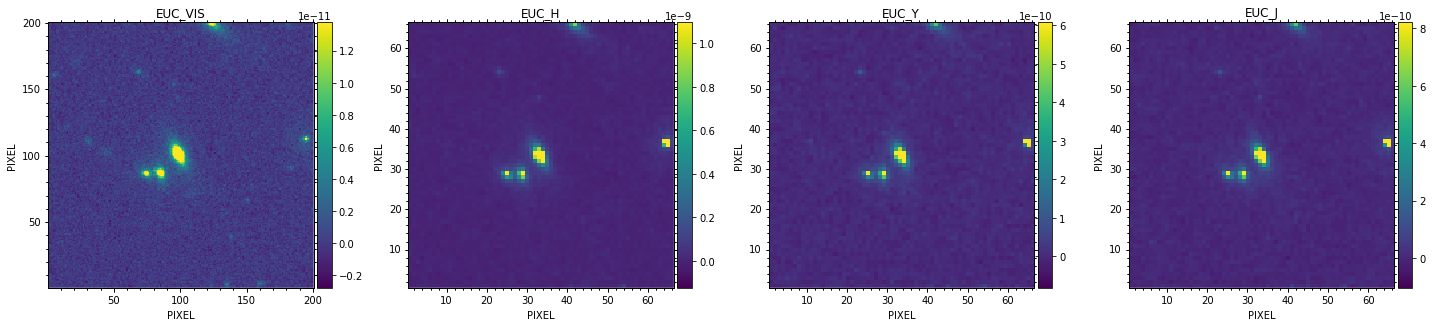

In [13]:
plot_all_bands_from_id(270610)

# Test  CNN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, Iterator

In [19]:
# From Tensorflow examples
batch_size = 24
epochs = 15
IMG_HEIGHT = 200
IMG_WIDTH = 200


In [20]:
image_data_generator = ImageDataGenerator(featurewise_center=False,
                                          samplewise_center=False,
                                          featurewise_std_normalization=False,
                                          samplewise_std_normalization=False,
                                          zca_whitening=False,
                                          zca_epsilon=1e-06,
                                          rotation_range=90,
                                          width_shift_range=0.0,
                                          height_shift_range=0.0,
                                          brightness_range=(0.8, 1.1),
                                          shear_range=0.0,
                                          zoom_range=(0.9, 1.1),
                                          channel_shift_range=0.0,
                                          fill_mode='nearest',
                                          cval=0.0,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rescale=None,
                                          preprocessing_function=None,
                                          data_format='channels_last',
                                          validation_split=0.2,
                                          dtype='float32')


def get_input(path):
    img = tifffile.imread(path)
    return img


def preprocess_input(image):
    return image
def augment_data(image):
    image = image_data_generator.random_transform(image)
    return image


def image_generator_dataframe(dataframe,
                              directory='',
                              x_col='filename',
                              y_col='class',
                              batch_size=64,
                              validation=False):
    files = dataframe[x_col].values
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a=files, size=batch_size)
        batch_input = []
        batch_output = []

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            input = get_input(os.path.join(directory, input_path))
            output = dataframe[dataframe[x_col] == input_path][y_col].values[0]
            input = preprocess_input(image=input)
            if not validation:
                input = augment_data(image=input)
            batch_input += [input]
            batch_output += [output]
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield (batch_x, batch_y)

In [21]:
lens_df = pd.read_csv(os.path.join(RESULTS, 'lens_id_labels.csv'), index_col = 0)
local_test_files = os.listdir(TRAIN_MULTIBAND)
local_test_id = [
    get_file_id(filename)
    for filename in local_test_files
]
local_test_df = pd.DataFrame()
local_test_df['filenames'] = local_test_files
local_test_df['labels'] = lens_df.loc[local_test_id, 'is_lens'].values.astype(int)
train_df, val_df = train_test_split(local_test_df, test_size=0.1, random_state=42)
total_train = len(train_df)
total_val = len(val_df)

NameError: name 'train_test_split' is not defined

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (10, 2.5))
for a in ax.ravel():
    img, label = next(
        image_generator_dataframe(local_test_df,
                                  directory=TRAIN_MULTIBAND,
                                  x_col='filenames',
                                  y_col='labels', batch_size = 1))
    a.imshow(img[0][:,:,2])
    a.set_xlabel(label[0])

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,4)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


In [22]:
train_data_gen = image_generator_dataframe(train_df,
                                  directory=TRAIN_MULTIBAND,
                                  x_col='filenames',
                                 y_col='labels', batch_size = batch_size)
val_data_gen = image_generator_dataframe(val_df,
                                  directory=TRAIN_MULTIBAND,
                                  x_col='filenames',
                                 y_col='labels', batch_size = batch_size, validation=True)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val
    
)

NameError: name 'train_df' is not defined

In [ ]:
class TiffImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super(TiffImageDataGenerator, self).__init__(*args, **kwargs)

    def flow_from_dataframe(self,
                            dataframe,
                            directory=None,
                            x_col="filename",
                            y_col="class",
                            weight_col=None,
                            target_size=(256, 256),
                            color_mode='rgb',
                            classes=None,
                            class_mode='categorical',
                            batch_size=32,
                            shuffle=True,
                            seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            subset=None,
                            interpolation='nearest',
                            validate_filenames=True,
                            **kwargs):
        """Takes the dataframe and the path to a directory
         and generates batches of augmented/normalized data.
        **A simple tutorial can be found **[here](
                                    http://bit.ly/keras_flow_from_dataframe).
        # Arguments
            dataframe: Pandas dataframe containing the filepaths relative to
                `directory` (or absolute paths if `directory` is None) of the
                images in a string column. It should include other column/s
                depending on the `class_mode`:
                - if `class_mode` is `"categorical"` (default value) it must
                    include the `y_col` column with the class/es of each image.
                    Values in column can be string/list/tuple if a single class
                    or list/tuple if multiple classes.
                - if `class_mode` is `"binary"` or `"sparse"` it must include
                    the given `y_col` column with class values as strings.
                - if `class_mode` is `"raw"` or `"multi_output"` it should contain
                the columns specified in `y_col`.
                - if `class_mode` is `"input"` or `None` no extra column is needed.
            directory: string, path to the directory to read images from. If `None`,
                data in `x_col` column should be absolute paths.
            x_col: string, column in `dataframe` that contains the filenames (or
                absolute paths if `directory` is `None`).
            y_col: string or list, column/s in `dataframe` that has the target data.
            weight_col: string, column in `dataframe` that contains the sample
                weights. Default: `None`.
            target_size: tuple of integers `(height, width)`, default: `(256, 256)`.
                The dimensions to which all images found will be resized.
            color_mode: one of "grayscale", "rgb", "rgba". Default: "rgb".
                Whether the images will be converted to have 1 or 3 color channels.
            classes: optional list of classes (e.g. `['dogs', 'cats']`).
                Default: None. If not provided, the list of classes will be
                automatically inferred from the `y_col`,
                which will map to the label indices, will be alphanumeric).
                The dictionary containing the mapping from class names to class
                indices can be obtained via the attribute `class_indices`.
            class_mode: one of "binary", "categorical", "input", "multi_output",
                "raw", sparse" or None. Default: "categorical".
                Mode for yielding the targets:
                - `"binary"`: 1D NumPy array of binary labels,
                - `"categorical"`: 2D NumPy array of one-hot encoded labels.
                    Supports multi-label output.
                - `"input"`: images identical to input images (mainly used to
                    work with autoencoders),
                - `"multi_output"`: list with the values of the different columns,
                - `"raw"`: NumPy array of values in `y_col` column(s),
                - `"sparse"`: 1D NumPy array of integer labels,
                - `None`, no targets are returned (the generator will only yield
                    batches of image data, which is useful to use in
                    `model.predict_generator()`).
            batch_size: size of the batches of data (default: 32).
            shuffle: whether to shuffle the data (default: True)
            seed: optional random seed for shuffling and transformations.
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: str. Prefix to use for filenames of saved pictures
                (only relevant if `save_to_dir` is set).
            save_format: one of "png", "jpeg"
                (only relevant if `save_to_dir` is set). Default: "png".
            follow_links: whether to follow symlinks inside class subdirectories
                (default: False).
            subset: Subset of data (`"training"` or `"validation"`) if
                `validation_split` is set in `ImageDataGenerator`.
            interpolation: Interpolation method used to resample the image if the
                target size is different from that of the loaded image.
                Supported methods are `"nearest"`, `"bilinear"`, and `"bicubic"`.
                If PIL version 1.1.3 or newer is installed, `"lanczos"` is also
                supported. If PIL version 3.4.0 or newer is installed, `"box"` and
                `"hamming"` are also supported. By default, `"nearest"` is used.
            validate_filenames: Boolean, whether to validate image filenames in
                `x_col`. If `True`, invalid images will be ignored. Disabling this
                option can lead to speed-up in the execution of this function.
                Default: `True`.
        # Returns
            A `DataFrameIterator` yielding tuples of `(x, y)`
            where `x` is a NumPy array containing a batch
            of images with shape `(batch_size, *target_size, channels)`
            and `y` is a NumPy array of corresponding labels.
        """
        if 'has_ext' in kwargs:
            warnings.warn(
                'has_ext is deprecated, filenames in the dataframe have '
                'to match the exact filenames in disk.', DeprecationWarning)
        if 'sort' in kwargs:
            warnings.warn(
                'sort is deprecated, batches will be created in the'
                'same order than the filenames provided if shuffle'
                'is set to False.', DeprecationWarning)
        if class_mode == 'other':
            warnings.warn(
                '`class_mode` "other" is deprecated, please use '
                '`class_mode` "raw".', DeprecationWarning)
            class_mode = 'raw'
        if 'drop_duplicates' in kwargs:
            warnings.warn(
                'drop_duplicates is deprecated, you can drop duplicates '
                'by using the pandas.DataFrame.drop_duplicates method.',
                DeprecationWarning)

        return image_generator_dataframe(self,
                                         dataframe,
                                         directory=directory,
                                         x_col=x_col,
                                         y_col=y_col,
                                         batch_size=batch_size)

# Test  RESTNET

In [15]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [16]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


In [17]:
# Load the CIFAR10 data.
train_data_gen = image_generator_dataframe(train_df,
                                  directory=TRAIN_MULTIBAND,
                                  x_col='filenames',
                                 y_col='labels', batch_size = batch_size)
val_data_gen = image_generator_dataframe(val_df,
                                  directory=TRAIN_MULTIBAND,
                                  x_col='filenames',
                                 y_col='labels', batch_size = batch_size, validation=True)

print('type of train_data_gen: ',type(train_data_gen))
print('type of val_data_gen: ',type(val_data_gen))
print('shape of train_data_gen: ',train_data_gen.shape)
print('shape of val_data_gen: ',val_data_gen.shape)



#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
#if subtract_pixel_mean:
#    x_train_mean = np.mean(x_train, axis=0)
#    x_train -= x_train_mean
#    x_test -= x_train_mean

#print('x_train shape:', x_train.shape)
#print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')
#print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


NameError: name 'train_data_gen' is not defined

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]






# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:

    # Fit the model on the batches generated by datagen.flow().
    #model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    #                    validation_data=(x_test, y_test),
    #                    epochs=epochs, verbose=1, workers=4,
    #                    callbacks=callbacks)
    #
    
     history = model.fit_generator(train_data_gen,
                                steps_per_epoch=total_train,
                                epochs=epochs,
                                validation_data=val_data_gen,
                                validation_steps=total_val)
    
    
# Score trained model.
scores = model.evaluate(val_data_gen, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])